# Tema 6 IDS

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import math

print(f'\tCurrent Numpy version: {np.__version__}')
print('\tNumpy version at the creation of the project: 1.20.2')

print(f'\n \tCurrent Pandas version: {pd.__version__}')
print('\tPandas version at the creation of the project: 1.2.4')

print(f'\n \tCurrent Regular Expressions version: {re.__version__}')
print('\tRegular Expressions version at the creation of the project: 2.2.1')

print(f'\n \tCurrent Seaborn version: {sns.__version__}')
print('\tSeaborn version at the creation of the project: 0.11.1')

	Current Numpy version: 1.20.2
	Numpy version at the creation of the project: 1.20.2

 	Current Pandas version: 1.2.4
	Pandas version at the creation of the project: 1.2.4

 	Current Regular Expressions version: 2.2.1
	Regular Expressions version at the creation of the project: 2.2.1

 	Current Seaborn version: 0.11.1
	Seaborn version at the creation of the project: 0.11.1


In [55]:
!pip install nltk

In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [69]:
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

## Setul de date `SMSSpamCollection`

### Descrierea setului de date

Setul de date `SMSSpamCollection` este un set de mesaje SMS care au fost colectate pentru a analiza SMS-urile de tip Spam. Acesta contine un set de 5574 mesaje text in limba engleza clasificate in 2 categorii: `ham`(mesaje legitime) sau `spam`.

Aceste mesaje au fost colectate din resurse gratuite de pe Web:
* O colectie de aproximativ 425 SMS-uri de tip spam extrase manual de pe site-ul [Grumbletext](http://www.grumbletext.co.uk). Acesta este un forum din UK in care utilizatorii telefoanelor mobile fac plangeri publice despre mesajele text de tip spam.
* O lista de 450 de SMS-uri legitime colectate din [teza de doctorat a lui Caroline Tag](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
* Un subset de 3375 mesaje legitime luate de pe site-ul [NUS SMS Corpus (NSC)](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/), un site care contine aproximativ 10000 de mesaje SMS legitime colectate pentru research de catre Department of Computer Science at the National University of Singapore. Mesajele provin in mare parte de la oamenii din Singapore si de la studentii de la universitate. Aceste mesaje au fost colectate de voluntari.
* Un numar de 1002 SMS-uri legitime si 332 SMS-uri de tip spam extrase din [SMS Spam Corpus v.0.1 Big](http://www.esp.uem.es/jmgomez/smsspamcorpus/), colectie creata de José María Gómez Hidalgo.

Setul de date contine un total de 4827 de SMS-uri de tip legitim (86.6%) si 747 de mesaje de tip spam (13.4%).

### Analiza exploratorie a setului de date

In [70]:
data = pd.read_csv("data/SMSSpamCollection", delimiter="\t", header=None)
data = data.rename(columns= {0: 'Type', 1:'Message'})

In [71]:
data.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [72]:
data.describe()

,Type,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [73]:
data['SMS_Length'] = data['Message'].apply(len)
data.head()

,Type,Message,SMS_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Putem observa din tabelul de mai jos urmatoarele detalii:
1. Numarul de mesaje legitime este mare in comparatie cu numarul mesajelor de tip spam.
2. Mesajele de tip spam sunt mai lungi decat mesajele legitime.
3. Lungimea medie pentru SMS-urile legitime este 71, insa lungimea maxima a unui mesaj din setul de date este 910.

In [74]:
data.groupby('Type').describe()

SMS_Length                                                         
          count        mean        std   min    25%    50%    75%    max
Type                                                                    
ham      4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam      747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

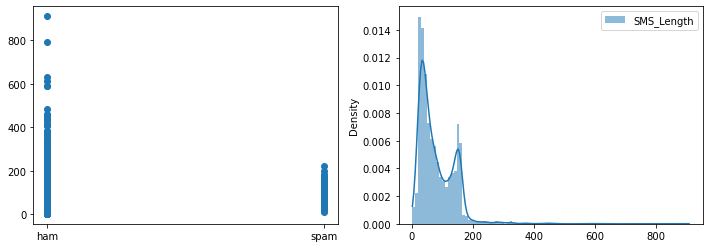

In [75]:
ply, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
axes[0].scatter(x='Type', y='SMS_Length', data=data)
sns.histplot(data, color='red', label='SMS_Length', kde=True, stat='density',linewidth=0);

Distributia lungimii SMS-urilor este foarte inclinata. De asemenea, putem observa valori aberante in categoria mesajelor legitime

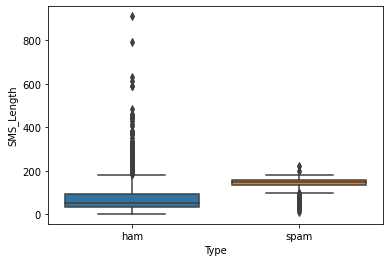

In [76]:
sns.boxplot(x='Type', y='SMS_Length', data=data);

Vom renunta la valorile aberante, adica la mesajele cu o lungime mai mare sau egala cu 790.

In [77]:
data[data['SMS_Length'] >= 790].index
data.drop(data[data['SMS_Length'] >= 790].index, axis = 0, inplace=True)

data.groupby('Type').describe()

SMS_Length                                                         
          count        mean        std   min    25%    50%    75%    max
Type                                                                    
ham      4823.0   71.159652  56.247168   2.0   33.0   52.0   93.0  629.0
spam      747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

### Preprocesarea datelor

In [78]:
def text_process(text):
    nopunct = [c for c in text if c not in string.punctuation]
    nopunct = ''.join(nopunct)
    clean_words = [word for word in nopunct.split() if word.lower() not in stopwords.words('english')]
    return clean_words

In [80]:
bow_transform = CountVectorizer(analyzer=text_process).fit_transform(data['Message'])

bow_transform.shape

(5570, 11403)

In [88]:
tfidf = TfidfVectorizer(analyzer=text_process).fit_transform(data['Message'])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(data['Message'], data['Type'], test_size=1/4, random_state=42)

In [91]:
from sklearn.naive_bayes import MultinomialNB

In [92]:
pipeline = Pipeline([('wordtokenizer', TfidfVectorizer(analyzer=text_process)), ('model', MultinomialNB())])

In [93]:
pipeline.fit(X_train, y_train);

Pipeline(steps=[('wordtokenizer',
                 TfidfVectorizer(analyzer=<function text_process at 0x000001BC8DA75040>)),
                ('model', MultinomialNB())])

In [94]:
preds = pipeline.predict(X_test)

In [97]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(preds, y_test))

print('Naive Bayes Accuracy Score: ', accuracy_score(preds, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1247
        spam       0.76      1.00      0.86       146

    accuracy                           0.97      1393
   macro avg       0.88      0.98      0.92      1393
weighted avg       0.97      0.97      0.97      1393

Naive Bayes Accuracy Score:  0.9669777458722182


In [110]:
y_data = data.iloc[:, 0]
X_data = data.iloc[:, -1]

In [111]:
print(f'X =\n {X_data}')
print(f'\n\ny =\n {y_data}')

X =
 0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: 1, Length: 5572, dtype: object


y =
 0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: 0, Length: 5572, dtype: object


In [112]:
import string
data = [line.translate(str.maketrans('','', string.punctuation)) for line in X_data]

In [113]:
X_data = np.array(data)

In [114]:
print(X_data)

['Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat'
 'Ok lar Joking wif u oni'
 'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive entry questionstd txt rateTCs apply 08452810075over18s'
 ... 'Pity  was in mood for that Soany other suggestions'
 'The guy did some bitching but I acted like id be interested in buying something else next week and he gave it to us for free'
 'Rofl Its true to its name']


In [115]:
y_data = np.where(y_data=='ham', 1, y_data)
y_data = np.where(y_data=='spam', 0, y_data)

print(y_data)

[1 1 0 ... 1 1 1]


In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 1/3)

In [117]:
print(X_train)

['Tell me again what your address is'
 'You have an important customer service announcement from PREMIER Call FREEPHONE 0800 542 0578 now'
 'Yo do you know anyone  ltgt  or otherwise able to buy liquor Our guy flaked and right now if we dont get a hold of somebody its just 4 loko all night'
 ...
 'Do you ever notice that when youre driving anyone going slower than you is an idiot and everyone driving faster than you is a maniac'
 ' sad puppy noise' 'Im going for bath will msg you next  ltgt  min']


In [118]:
print(X_test)

['Ki didt see youkwhere are you now' 'MMM  Fuck  Merry Christmas to me'
 'Hey gorgeous man My work mobile number is Have a good one babe Squishy Mwahs'
 ...
 'Yeah we can probably swing by once my roommate finishes up with his girl'
 'What happen dear Why you silent I am tensed'
 'Compliments to you Was away from the system How your side']


In [119]:
print(y_train)

[1 0 1 ... 0 1 1]


In [120]:
print(y_test)

[1 1 1 ... 1 1 1]


Bag of Words

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
print(repr(X_train))

X_test = vect.fit_transform(X_test)

<3714x7598 sparse matrix of type '<class 'numpy.int64'>'
	with 48980 stored elements in Compressed Sparse Row format>


In [122]:
print(f'Dimensiune vocabular: {len(vect.vocabulary_)}')

Dimensiune vocabular: 4969


In [123]:
feature_names = vect.get_feature_names()
print(f'Dimensiunea vocabularului: {len(feature_names)}')

Dimensiunea vocabularului: 4969


In [124]:
print(feature_names[:20])

['020603', '0207', '02073162414', '02085076972', '050703', '06', '07008009200', '0721072', '07732584351', '07815296484', '07821230901', '0796xxxxxx', '07xxxxxxxxx', '0800', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812']


In [125]:
print(feature_names[-20:])

['yourjob', 'yours', 'yourself', 'youso', 'youve', 'yoville', 'yr', 'yrs', 'yummmm', 'yun', 'yunny', 'yuou', 'yup', 'yupz', 'ywhere', 'zed', 'zoe', 'zogtorius', 'zoom', 'üll']


In [126]:
print(feature_names[2000:2020])

['govtinstituitions', 'gprs', 'gpu', 'gr8', 'grab', 'grahmbell', 'gram', 'grand', 'grandfather', 'grandma', 'granted', 'graphics', 'grave', 'gray', 'great', 'greatbhaji', 'greatbye', 'green', 'greet', 'greeting']


In [127]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [ ]:
scores = cross_validate(LogisticRegression(), X_train, y_train, cv=5, scoring=['f1_macro', 'accuracy'])